
# Malware Detection — Combined Dataset Training & Evaluation

This notebook trains models on `data/EDA/Cleaned_combined_malware_dataset.csv` (PE header + process stats).  
Target column: **`legitimate`** (1 = benign, 0 = malware).

Models:
- **Classification:** Logistic Regression (scaled), SVM RBF (scaled), Random Forest (constrained)
- **Clustering:** K-Means (k=2), DBSCAN
- **Outputs:** ROC curves (LR & SVM), RF feature importances, metrics table (`artifacts/classifier_metrics_combined.csv`)


In [1]:

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, classification_report, roc_curve, ConfusionMatrixDisplay
)
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, adjusted_rand_score

# Paths
DATA_PATH = os.path.join("EDA", "Cleaned_combined_malware_dataset.csv")
ART_DIR = os.path.join("artifacts")
PLOT_DIR = os.path.join(ART_DIR, "plots")
os.makedirs(PLOT_DIR, exist_ok=True)

print("Reading:", DATA_PATH)


Reading: EDA\Cleaned_combined_malware_dataset.csv


In [2]:

df = pd.read_csv(DATA_PATH)

# Drop accidental unnamed columns
drop_un = [c for c in df.columns if str(c).lower().startswith("unnamed") or str(c).strip() == ""]
if drop_un:
    df = df.drop(columns=drop_un)
    print("Dropped accidental columns:", drop_un)

if "legitimate" not in df.columns:
    raise ValueError("Expected 'legitimate' column in combined dataset. Found: " + str(list(df.columns)))

print("Shape:", df.shape)
print("Columns:", list(df.columns)[:10], "...")
display(df.head())


Dropped accidental columns: ['Unnamed: 0']
Shape: (138047, 55)
Columns: ['Machine', 'SizeOfOptionalHeader', 'Characteristics', 'MajorLinkerVersion', 'MinorLinkerVersion', 'SizeOfCode', 'SizeOfInitializedData', 'SizeOfUninitializedData', 'AddressOfEntryPoint', 'BaseOfCode'] ...


,Machine,SizeOfOptionalHeader,Characteristics,MajorLinkerVersion,MinorLinkerVersion,SizeOfCode,SizeOfInitializedData,SizeOfUninitializedData,AddressOfEntryPoint,BaseOfCode,...,ResourcesNb,ResourcesMeanEntropy,ResourcesMinEntropy,ResourcesMaxEntropy,ResourcesMeanSize,ResourcesMinSize,ResourcesMaxSize,LoadConfigurationSize,VersionInformationSize,legitimate
0,-0.360934,224,258,9,-0.321959,0.020747,-0.015930,-0.006173,-0.048337,-0.009715,...,-0.132246,3.262823,2.568844,3.537939,-0.005982,-0.002763,-0.010756,-0.017849,16,1
1,-0.360934,224,3330,9,-0.321959,-0.019469,-0.020485,-0.006173,-0.026287,-0.009715,...,-0.146898,4.250461,3.420744,5.080177,-0.007003,-0.002716,-0.011551,-0.017846,18,1
2,-0.360934,224,3330,9,-0.321959,0.047706,0.008141,-0.006173,0.052161,-0.009715,...,-0.080961,4.426324,2.846449,5.271813,-0.003122,-0.002780,0.001119,-0.017846,18,1
3,-0.360934,224,258,9,-0.321959,0.059629,-0.003870,-0.006173,0.081416,-0.009715,...,-0.088288,4.364291,2.669314,6.400720,-0.006923,-0.002782,-0.011404,-0.017846,18,1
4,-0.360934,224,258,9,-0.321959,0.009091,-0.009668,-0.006173,0.013241,-0.009715,...,-0.146898,4.306100,3.421598,5.190603,-0.006972,-0.002665,-0.011544,-0.017846,18,1


In [3]:

# Features/labels
X = df.drop(columns=["legitimate"]).copy()
y = df["legitimate"].astype(int)

# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

# Scaled versions for LR/SVM
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

print("Train:", X_train.shape, "| Test:", X_test.shape)


Train: (110437, 54) | Test: (27610, 54)


In [4]:

def report_classifier(name, y_true, y_pred, y_prob=None):
    print(f"\n=== {name} ===")
    print(classification_report(y_true, y_pred))
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_prob) if y_prob is not None else float("nan")
    print(f"Accuracy={acc:.5f}, Precision={prec:.5f}, Recall={rec:.5f}, F1={f1:.5f}, ROC AUC={auc:.5f}")
    return {"model": name, "accuracy": acc, "precision": prec, "recall": rec, "f1": f1, "roc_auc": auc}



=== Logistic Regression (scaled) ===
              precision    recall  f1-score   support

           0       0.98      0.99      0.99     19345
           1       0.97      0.96      0.97      8265

    accuracy                           0.98     27610
   macro avg       0.98      0.97      0.98     27610
weighted avg       0.98      0.98      0.98     27610

Accuracy=0.97943, Precision=0.97169, Recall=0.95923, F1=0.96542, ROC AUC=0.99545


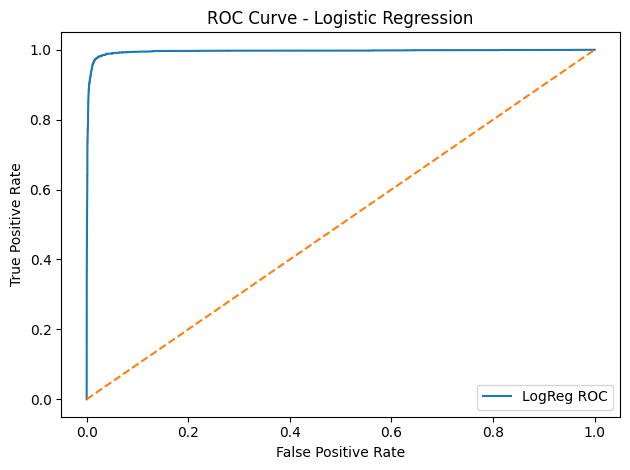

In [5]:

# Logistic Regression (scaled)
logreg = LogisticRegression(max_iter=5000, solver="saga", n_jobs=-1)
logreg.fit(X_train_scaled, y_train)
y_pred_lr = logreg.predict(X_test_scaled)
y_prob_lr = logreg.predict_proba(X_test_scaled)[:, 1]
m_lr = report_classifier("Logistic Regression (scaled)", y_test, y_pred_lr, y_prob_lr)

# ROC curve
fpr, tpr, _ = roc_curve(y_test, y_prob_lr)
plt.figure()
plt.plot(fpr, tpr, label="LogReg ROC")
plt.plot([0,1],[0,1],'--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Logistic Regression")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(PLOT_DIR, "roc_logreg_combined.png"), dpi=160, bbox_inches="tight")
plt.show()



=== SVM RBF (scaled) ===
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     19345
           1       0.98      0.98      0.98      8265

    accuracy                           0.99     27610
   macro avg       0.99      0.99      0.99     27610
weighted avg       0.99      0.99      0.99     27610

Accuracy=0.98881, Precision=0.98195, Recall=0.98064, F1=0.98129, ROC AUC=0.99740


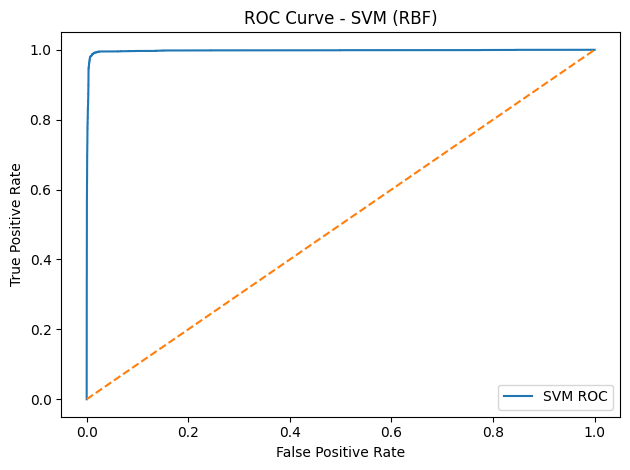

In [6]:

# SVM RBF (scaled)
svm = SVC(kernel="rbf", probability=True, random_state=42)
svm.fit(X_train_scaled, y_train)
y_pred_svm = svm.predict(X_test_scaled)
y_prob_svm = svm.predict_proba(X_test_scaled)[:, 1]
m_svm = report_classifier("SVM RBF (scaled)", y_test, y_pred_svm, y_prob_svm)

# ROC curve
fpr, tpr, _ = roc_curve(y_test, y_prob_svm)
plt.figure()
plt.plot(fpr, tpr, label="SVM ROC")
plt.plot([0,1],[0,1],'--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - SVM (RBF)")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(PLOT_DIR, "roc_svm_combined.png"), dpi=160, bbox_inches="tight")
plt.show()



=== Random Forest (constrained) ===
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19345
           1       0.99      0.99      0.99      8265

    accuracy                           0.99     27610
   macro avg       0.99      0.99      0.99     27610
weighted avg       0.99      0.99      0.99     27610

Accuracy=0.99315, Precision=0.98874, Recall=0.98838, F1=0.98856, ROC AUC=0.99965


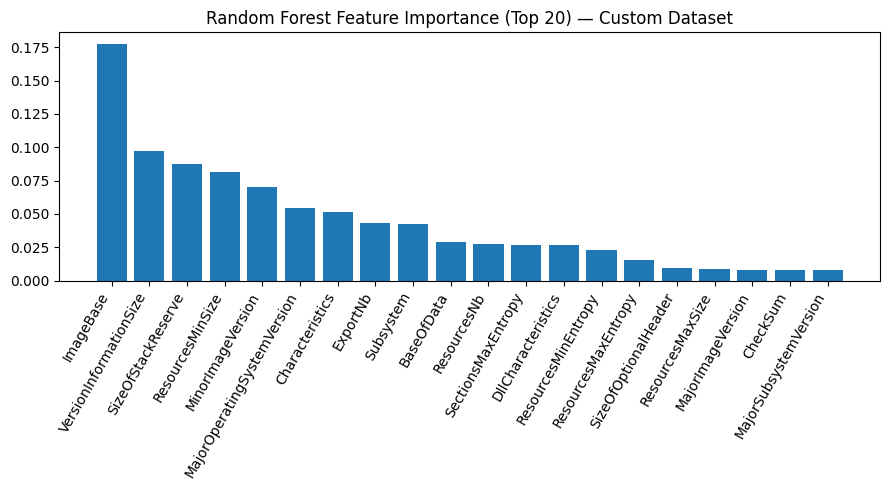


Top 20 RF features:
ImageBase                           0.1773
VersionInformationSize              0.0969
SizeOfStackReserve                  0.0875
ResourcesMinSize                    0.0813
MinorImageVersion                   0.0703
MajorOperatingSystemVersion         0.0541
Characteristics                     0.0518
ExportNb                            0.0432
Subsystem                           0.0426
BaseOfData                          0.0287
ResourcesNb                         0.0272
SectionsMaxEntropy                  0.0268
DllCharacteristics                  0.0263
ResourcesMinEntropy                 0.0233
ResourcesMaxEntropy                 0.0156
SizeOfOptionalHeader                0.0095
ResourcesMaxSize                    0.0083
MajorImageVersion                   0.0082
CheckSum                            0.0080
MajorSubsystemVersion               0.0078


In [7]:

# Random Forest (constrained)
rf = RandomForestClassifier(
    n_estimators=300, max_depth=15, min_samples_leaf=5, random_state=42, n_jobs=-1
)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
y_prob_rf = rf.predict_proba(X_test)[:, 1]
m_rf = report_classifier("Random Forest (constrained)", y_test, y_pred_rf, y_prob_rf)

# Feature importances
importances = rf.feature_importances_
idx = np.argsort(importances)[::-1][:20]
top_feats = [X.columns[i] for i in idx]

plt.figure(figsize=(9,5))
plt.bar(range(len(idx)), importances[idx])
plt.xticks(range(len(idx)), top_feats, rotation=60, ha='right')
plt.title("Random Forest Feature Importance (Top 20) — Custom Dataset")
plt.tight_layout()
plt.savefig(os.path.join(PLOT_DIR, "rf_importances_combined.png"), dpi=160, bbox_inches="tight")
plt.show()

print("\nTop 20 RF features:")
for name, val in zip(top_feats, importances[idx]):
    print(f"{name:35s} {val:.4f}")


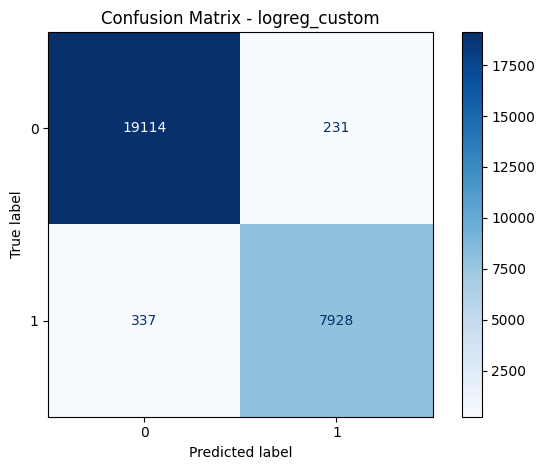

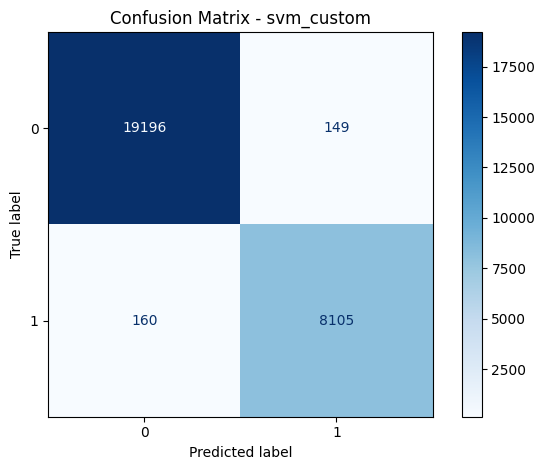

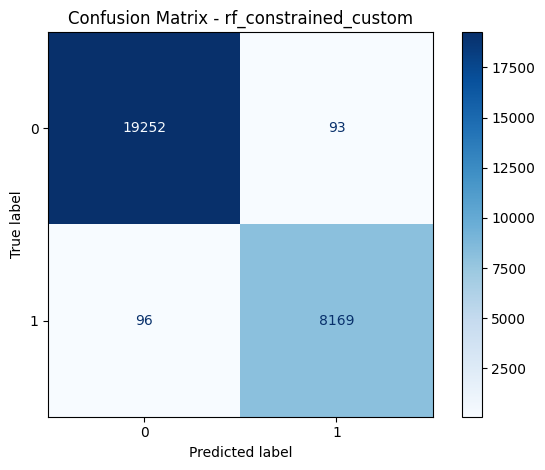

In [8]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
import os

# ensure output folder exists
os.makedirs("artifacts/plots/custom", exist_ok=True)

# use the predictions you actually computed
for name, y_pred in [
    ("logreg_custom", y_pred_lr),
    ("svm_custom", y_pred_svm),
    ("rf_constrained_custom", y_pred_rf),  # was y_pred_rf_c (undefined)
]:
    disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap="Blues")
    plt.title(f"Confusion Matrix - {name}")
    plt.tight_layout()
    plt.savefig(f"artifacts/plots/custom/cm_{name}.png", dpi=160, bbox_inches="tight")
    plt.show()



In [9]:

# Clustering
print("\n--- Clustering ---")

scaler_km = StandardScaler()
X_all_scaled = scaler_km.fit_transform(X)

# K-Means
kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
labels_km = kmeans.fit_predict(X_all_scaled)
sil_km = silhouette_score(X_all_scaled, labels_km)
ari_km = adjusted_rand_score(y, labels_km)
print(f"K-Means (k=2): Silhouette={sil_km:.5f}, ARI={ari_km:.5f}")

# DBSCAN
dbscan = DBSCAN(eps=0.8, min_samples=15, n_jobs=-1)
labels_db = dbscan.fit_predict(X_all_scaled)
valid = labels_db != -1
if valid.sum() > 1 and len(set(labels_db[valid])) > 1:
    sil_db = silhouette_score(X_all_scaled[valid], labels_db[valid])
    ari_db = adjusted_rand_score(y[valid], labels_db[valid])
else:
    sil_db, ari_db = float("nan"), float("nan")
unique, counts = np.unique(labels_db, return_counts=True)
print("DBSCAN clusters:", dict(zip(unique, counts)))
print(f"DBSCAN (non-noise): Silhouette={sil_db:.5f}, ARI={ari_db:.5f}")



--- Clustering ---
K-Means (k=2): Silhouette=0.27000, ARI=0.77043
DBSCAN clusters: {np.int64(-1): np.int64(24649), np.int64(0): np.int64(19), np.int64(1): np.int64(54), np.int64(2): np.int64(81), np.int64(3): np.int64(16), np.int64(4): np.int64(1553), np.int64(5): np.int64(100), np.int64(6): np.int64(287), np.int64(7): np.int64(444), np.int64(8): np.int64(231), np.int64(9): np.int64(15), np.int64(10): np.int64(44), np.int64(11): np.int64(60), np.int64(12): np.int64(33), np.int64(13): np.int64(38), np.int64(14): np.int64(63), np.int64(15): np.int64(122), np.int64(16): np.int64(50), np.int64(17): np.int64(24), np.int64(18): np.int64(16), np.int64(19): np.int64(35), np.int64(20): np.int64(35), np.int64(21): np.int64(32), np.int64(22): np.int64(32), np.int64(23): np.int64(95), np.int64(24): np.int64(37), np.int64(25): np.int64(30), np.int64(26): np.int64(69), np.int64(27): np.int64(20), np.int64(28): np.int64(808), np.int64(29): np.int64(969), np.int64(30): np.int64(538), np.int64(31): np

In [10]:

# Save metrics table
metrics = pd.DataFrame([m_lr, m_svm, m_rf])
csv_path = os.path.join(ART_DIR, "classifier_metrics_combined.csv")
os.makedirs(ART_DIR, exist_ok=True)
metrics.to_csv(csv_path, index=False)
print("Saved metrics to:", csv_path)
metrics


Saved metrics to: artifacts\classifier_metrics_combined.csv


,model,accuracy,precision,recall,f1,roc_auc
0,Logistic Regression (scaled),0.979428,0.971688,0.959226,0.965416,0.995450
1,SVM RBF (scaled),0.988808,0.981948,0.980641,0.981294,0.997395
2,Random Forest (constrained),0.993155,0.988744,0.988385,0.988564,0.999647


In [11]:
import joblib
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ("scaler", scaler),          
    ("clf", svm)                 
])
pipeline.fit(X_train, y_train)
_ = pipeline.predict(X_test)
joblib.dump(pipeline, "artifacts/model_pipeline.joblib")
getattr(pipeline, "feature_names_in_", None)


array(['Machine', 'SizeOfOptionalHeader', 'Characteristics',
       'MajorLinkerVersion', 'MinorLinkerVersion', 'SizeOfCode',
       'SizeOfInitializedData', 'SizeOfUninitializedData',
       'AddressOfEntryPoint', 'BaseOfCode', 'BaseOfData', 'ImageBase',
       'SectionAlignment', 'FileAlignment', 'MajorOperatingSystemVersion',
       'MinorOperatingSystemVersion', 'MajorImageVersion',
       'MinorImageVersion', 'MajorSubsystemVersion',
       'MinorSubsystemVersion', 'SizeOfImage', 'SizeOfHeaders',
       'CheckSum', 'Subsystem', 'DllCharacteristics',
       'SizeOfStackReserve', 'SizeOfStackCommit', 'SizeOfHeapReserve',
       'SizeOfHeapCommit', 'LoaderFlags', 'NumberOfRvaAndSizes',
       'SectionsNb', 'SectionsMeanEntropy', 'SectionsMinEntropy',
       'SectionsMaxEntropy', 'SectionsMeanRawsize', 'SectionsMinRawsize',
       'SectionMaxRawsize', 'SectionsMeanVirtualsize',
       'SectionsMinVirtualsize', 'SectionMaxVirtualsize', 'ImportsNbDLL',
       'ImportsNb', 'ImportsNbOrdi


## Wrap-up

- **Best supervised model** is typically **SVM (RBF)** or **constrained Random Forest** on this combined dataset.
- ROC curves and feature importances are saved to `artifacts/plots/`.
- Metrics table saved to `artifacts/classifier_metrics_combined.csv`
